In [1]:
# uncomment this line to install dependencies
# !conda install -f environment.yml

# A gentle introduction to Bayesian statistics and modeling
## Part II - Bayes by example

by Brian Groenke

These notebooks act as the second part of a two-part workshop on Bayesian statistics and modeling.

The examples were originally conceptualized and implemented in June 2021 at the Alfred Wegener Institute Helmholtz Centre for Polar and Marine Research in Potsdam.

They have since been overhauled and expanded in July 2024 at the Environmental Research Centre Leipzig.

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats

# the Bayesian stuff
import pymc as pm

# the frequentist stuff 
import statsmodels.api as sm

# plotting
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# RNG
rng = np.random.default_rng(seed=20212206)

## Example 1: Introduction to probabilistic modeling

Scientific hypotheses typically attempt to relate a set of **dependent variables** to a set of **independent variables** via some kind of statistical or process-based relationship.

Programming languages allow us to encode these relationships as *programs* and then analyze the output.

In [3]:
def determinsitic_linear(X, slope, intercept):
    y = np.matmul(X, slope) + intercept
    return y

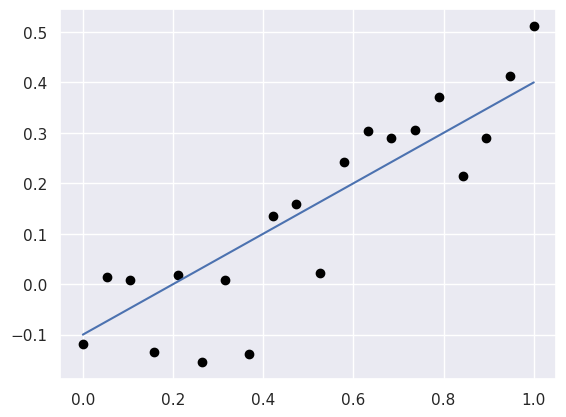

In [4]:
n_obs = 20
X = np.linspace(0.0,1.0,n_obs).reshape((-1,1))
true_slope = np.array([0.5])
true_intercept = np.array([-0.1])
true_sigma = 0.1
y_pred = determinsitic_linear(X, true_slope, true_intercept)
y_obs = y_pred + rng.standard_normal(n_obs)*true_sigma
plt.scatter(X, y_obs, c='black');
plt.plot(X, y_pred);

### Probabilistic modeling

**Deterministic** models map a single set of inputs to a single output.

**Probabilistic** models directly incorporate **random variables** and probability distributions to represent in uncertainty in their outputs.

The output of a probabilistic model is a **distribution** rather than a single value.

One of the simplest examples of a probabilistic model is a linear regression with Gaussian noise:

$$
\begin{align*}
y &\sim \mathcal{N}(\mu,\sigma^2) \\
\mu &= \beta_0 + \beta_1 X
\end{align*}
$$
where $\beta_0$ and $\beta_1$ are the intercept and slope parameters respectively. $\sigma$ is the standard deviation of the residuals.

### Probabilistic programming

A program which incorporates such probabilisic elements is referred to as a *probabilistic program*.

We can use probabilistic programming to implement our probabilistic models.

In [5]:
def stochastic_linear(X, slope, intercept, var=1.0):
    y_mean = np.matmul(X, slope) + intercept
    y = rng.normal(y_mean, np.sqrt(var))
    return y, y_mean

Since the model is stochastic, we can run it many times and then plot the distribution of outcomes.

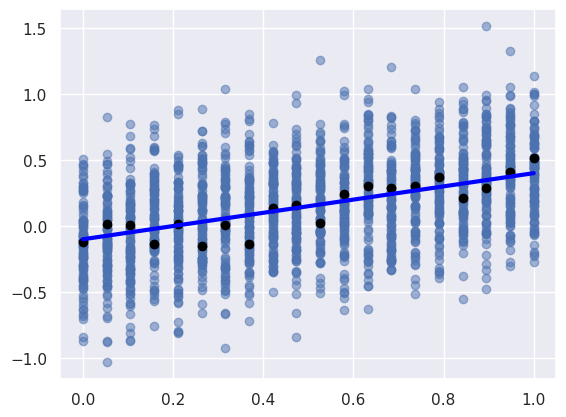

In [6]:
n_samples = 100
y_sims = [stochastic_linear(X, true_slope, true_intercept, var=true_sigma) for i in range(n_samples)]
y_samples = np.array([y for y, _ in y_sims])
y_means = np.array([y_mean for _, y_mean in y_sims])
plt.scatter(X*np.ones((1,n_samples)), y_samples.T, alpha=0.5)
plt.plot(X, np.mean(y_means, axis=0), c='blue', linewidth=3.0)
plt.scatter(X, y_obs, c='black');

### Bayesian probabilistic modeling


Note that this probabilistic model is not yet Bayesian since we are only modeling the *aleatoric uncertainty* in the observation $y$.

In the Bayesian setting, we are additionally interested in the *epistemic uncertainty* arising from all sources of uncertainty in the model.

Let's update our model to be more Bayesian.

$$
\begin{align*}
y &\sim \mathcal{N}(\mu_y,\sigma^2) \\
\mu_y &= \beta_0 + \beta_1 X \\
\beta_0 &\sim \mathcal{N}(\mu_0, \sigma^2) \\ 
\beta_1 &\sim \mathcal{N}(\mu_1, \sigma^2) \\
\sigma^2 &\sim \text{InvGamma}(2, \sigma_0)
\end{align*}
$$

This is the canonical Bayesian linear regression with a so-called "conjugate prior" $p(\beta_0,\beta_1,\sigma^2)$.

In [7]:
def bayesian_linear(rng, X, slope_mean, intercept_mean, var_mean=1.0):
    # sample variance from canonincal inverse gamma conjugate prior
    var = stats.invgamma.rvs(2, scale=var_mean, random_state=rng)
    sigma = np.sqrt(var)
    # normally distributed coefficients
    slope = rng.normal(slope_mean, sigma)
    intercept = rng.normal(intercept_mean, sigma)
    # mean prediction
    y_mean = np.matmul(X, slope) + intercept
    # add noise
    y = rng.normal(y_mean, sigma)
    return y, y_mean

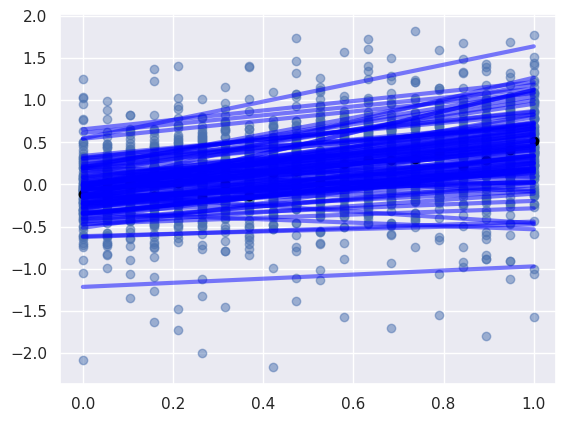

In [8]:
n_samples = 100
y_sims = [bayesian_linear(rng, X, true_slope, true_intercept, var_mean=true_sigma) for i in range(n_samples)]
y_samples = np.array([y for y, _ in y_sims])
y_means = np.array([y_mean for _, y_mean in y_sims])
plt.scatter(X*np.ones((1,n_samples)), y_samples.T, alpha=0.5)
plt.plot(X*np.ones((1,n_samples)), y_means.T, c='blue', linewidth=3.0, alpha=0.5)
plt.scatter(X, y_obs, c='black');

We now have not only a distribution over the residuals but also over the predicted mean.

In the language of Bayesian modeling, the distribution of regression lines seen here is called the **prior predictive mean**.

### Inference

- So far we have only constructed **forward models** of outputs given some inputs.

- In most use cases where we have "real" data, the unobserved variables need to be **inferred** from the observations.

- In this specific case, there is an analytical solution for the posterior $p(\beta_0,\beta_1,\sigma^2|y,X)$ to which we can compare.

- For the sake of sanity, we will not dicuss the details of the analytical solution here.

See the notebook online for details.

See also the [BayesianRidge](https://scikit-learn.org/stable/modules/linear_model.html#bayesian-ridge-regression) regressor in scikit-learn for a similar (though not identical) implementation.

In [9]:
class BayesLinearRegression:
    def __init__(self, X, y,
                 slope_mean=np.zeros(X.shape[1]), intercept_mean=np.zeros(1),
                 var_mean=None, prior_coef_scale=10.0, prior_var_shape=2.0):
        """Computes the posterior distribution of canonical Bayesian linear regression with
        conjugate Gaussian and inverse-Gamma priors. The inverse-Gamma distributed variance
        is paramterized in terms of its mean `var_mean` and shape parameter `prior_var_shape`.
        The parameter `prior_coef_scale` represents the standard deviation (scale) of the
        regression coeffficient prior. The prior precision matrix is scaled by the square-ineverse
        of this hyperparameter. Smaller values increase the influence of the prior.
    
        See https://en.wikipedia.org/wiki/Bayesian_linear_regression#Posterior_distribution
        for more details.
        """
        N, k = X.shape
        var_mean = np.var(y) if var_mean is None else var_mean
        # add constant dimension to design matrix X for convenience
        Xc = sm.add_constant(X)
        # compute square matrix
        XX = np.matmul(Xc.T, Xc)
        # compute inverse of square matrix; note the use of pinv for numerical stability
        XXinv = np.linalg.pinv(XX)
        # least squares estimator
        self.beta_lsq = beta_lsq = np.matmul(XXinv, np.matmul(Xc.T, y))
        # prior mean for regression coefficients (here referred to as beta)
        self.prior_beta = prior_beta = np.concatenate([slope_mean, intercept_mean], axis=0)
        # prior scale parameter for inverse-gamma
        self.prior_var_scale = prior_var_scale = var_mean*(prior_var_shape - 1)
        # compute prior precision for homeoscedastic covariance scaled by prior_coef_scale
        self.prior_prec = prior_prec = np.eye(k+1)/prior_coef_scale**2
        # posterior precision matrix
        self.posterior_prec = posterior_prec = XX + prior_prec
        # compute posterior covariance as inverse of precision
        self.posterior_cov = np.linalg.inv(self.posterior_prec)
        # posterior normal mean
        self.posterior_beta = posterior_beta = np.matmul(np.linalg.pinv(posterior_prec),
                                                         np.matmul(XX, beta_lsq) + np.matmul(prior_prec, prior_beta))
        # posterior noise variance inverse-gamma shape
        self.posterior_var_shape = prior_var_shape + N/2
        # posterior noise variance inverse-gamma scale
        self.posterior_var_scale = prior_var_scale + \
            (np.matmul(y.T, y) + \
            np.matmul(prior_beta.T, np.matmul(prior_prec, prior_beta)) - \
            np.matmul(posterior_beta.T, np.matmul(posterior_prec, posterior_beta)))/2

    def predict(self, X):
        Xc = sm.add_constant(X)
        beta = self.posterior_mean
        return np.matmul(Xc, beta)

    def sample_predict(self, X):
        Xc = sm.add_constant(X)
        beta, _ = self.sample()
        return np.matmul(Xc, beta)
    
    def logpdf(self, beta, var):
        beta_cond = stats.multivariate_normal(self.posterior_beta, var*self.posterior_cov)
        ig = stats.invgamma(self.posterior_var_shape, scale=self.posterior_var_scale)
        return beta_cond.logpdf(beta) + ig.logpdf(var)

    def sample(self):
        var = stats.invgamma(self.posterior_var_shape, scale=self.posterior_var_scale).rvs()
        beta = stats.multivariate_normal(self.posterior_beta, var*self.posterior_cov).rvs()
        return beta, var

    def mean(self):
        var = stats.invgamma(self.posterior_var_shape, scale=self.posterior_var_scale).mean()
        beta = self.posterior_beta
        return beta, var

In [10]:
reg = BayesLinearRegression(X, y_obs)
coef_mean, var_mean = reg.mean()
print("posterior mean:")
print(f"slope: {coef_mean[0]}")
print(f"intercept: {coef_mean[1]}")
print(f"variance: {var_mean}")

posterior mean:
slope: -0.14510857166322966
intercept: 0.5662395320715664
variance: 0.01131389937655991


Let's compare now to a classical OLS (frequestist) regression analysis.

In [11]:
Xc = sm.add_constant(X)
res = sm.OLS(y_obs, Xc).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.768
Method:                 Least Squares   F-statistic:                     63.76
Date:                Mon, 26 Aug 2024   Prob (F-statistic):           2.52e-07
Time:                        07:52:27   Log-Likelihood:                 19.369
No. Observations:                  20   AIC:                            -34.74
Df Residuals:                      18   BIC:                            -32.75
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1469      0.042     -3.520      0.002      -0.235      -0.059
x1             0.5697      0.071      7.985      0.000       0.420       0.720
==============================================================================
Omnibus:                        2.574   Durbin-Watson:                   1.926
Prob(Omnibus):                  0.276   Jarque-Bera (JB):                2.127
Skew:                          -0.734   Prob(JB):                        0.345
Kurtosis:                       2.371   Cond. No.                         4.18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We can generate predictions from the Bayesian model by sampling from the posterior distribution.

In [12]:
n_samples = 1000
preds = np.array([reg.sample_predict(X) for i in range(n_samples)])
# calculate quantiles
pred_lo = np.quantile(preds, 0.025, axis=0)
pred_mid = np.quantile(preds, 0.5, axis=0)
pred_hi = np.quantile(preds, 0.975, axis=0)

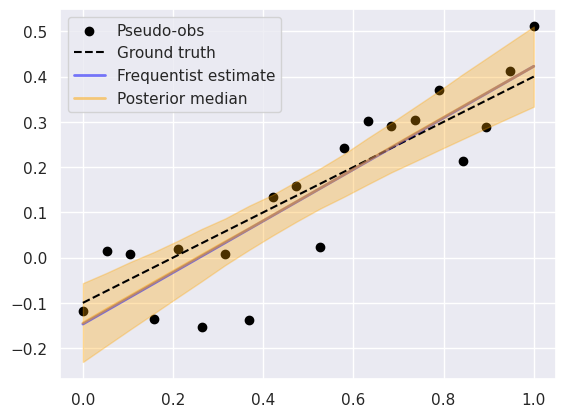

In [13]:
plt.scatter(X, y_obs, c='black', label="Pseudo-obs")
plt.plot(X, y_pred, c='black', linestyle='--', label="Ground truth")
plt.plot(X, res.predict(Xc), c='blue', label="Frequentist estimate", linewidth=2, alpha=0.5);
plt.plot(X, pred_mid, c='orange', label="Posterior median", linewidth=2, alpha=0.5)
plt.fill_between(X[:,0], pred_lo, pred_hi, color='orange', alpha=0.3)
plt.legend()
plt.show()

Of course we can increase the number of observations to get a better fit for both the Bayesian and Frequentist models.

In [14]:
n_obs = 100
X = np.linspace(0.0,1.0,n_obs).reshape((-1,1))
y_pred = determinsitic_linear(X, true_slope, true_intercept)
y_obs = y_pred + rng.normal(0, true_sigma, size=n_obs)
new_reg = BayesLinearRegression(X, y_obs)
preds = np.array([new_reg.sample_predict(X) for i in range(n_samples)])
# calculate quantiles
pred_lo = np.quantile(preds, 0.025, axis=0)
pred_mid = np.quantile(preds, 0.5, axis=0)
pred_hi = np.quantile(preds, 0.975, axis=0)
new_res = sm.OLS(y_obs, sm.add_constant(X)).fit()

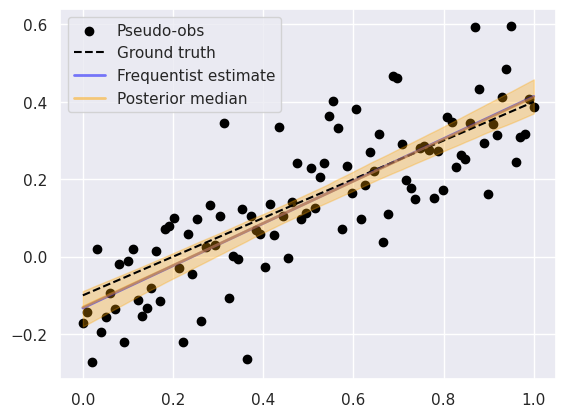

In [15]:
plt.scatter(X, y_obs, c='black', label="Pseudo-obs")
plt.plot(X, y_pred, c='black', linestyle='--', label="Ground truth")
plt.plot(X, new_res.predict(sm.add_constant(X)), c='blue', label="Frequentist estimate", linewidth=2, alpha=0.5);
plt.plot(X, pred_mid, c='orange', label="Posterior median", linewidth=2, alpha=0.5)
plt.fill_between(X[:,0], pred_lo, pred_hi, color='orange', alpha=0.3)
plt.legend()
plt.show()

### Numerical inference with Markov Chain Monte Carlo

In the previous example, we were able to employ an analytical solution for the Gaussian posterior.

For most models, no such closed-form solution exists.

Thus, we must resort to **numerical sampling** methods like **Markov Chain Monte Carlo** (MCMC).

Let $f(\theta) = p(\mathcal{D},\theta) = p(\mathcal{D}|\theta)p(\theta)$

1. Choose some starting point $\theta_0$.

2. Sample a new *proposed* point $\theta^*$ from a **proposal distribution**.

3. If $f({\theta}^* ) > f(\theta_0)$, accept $\theta^*$ as the new starting point.

4. Otherwise, accept with probability $\frac{f(\theta^*)}{f(\theta_0)}$ or reject the proposed sample.

The last step is crucial and is called the **Metropolis-Hastings** correction.

Let's look again at our probabilistic program from the previous example.

In [16]:
def bayesian_linear(rng, X, slope_mean, intercept_mean, var_mean=1.0):
    # sample variance from canonincal inverse gamma conjugate prior
    var = stats.invgamma.rvs(2, scale=var_mean, random_state=rng)
    sigma = np.sqrt(var)
    # normally distributed coefficients
    slope = rng.normal(slope_mean, sigma)
    intercept = rng.normal(intercept_mean, sigma)
    # mean prediction
    y_mean = np.matmul(X, slope) + intercept
    # add noise
    y = rng.normal(y_mean, sigma)
    return y, y_mean

This program is a *forward* model. It can generate samples but cannot evaluate densities.

In order to do this, we would need to write a separate inference program or augment this one.

Let's do this for demonstration purposes.

We can augment the program to keep track of random variables in a dictionary.

In [17]:
def tracked_bayesian_linear(rng, variables: dict, X,
                            slope_mean=np.zeros(1), intercept_mean=np.zeros(1),
                            var_mean=1.0, coef_scale=10.0):
    logprob = 0.0
    if "var" in variables:
        var = variables["var"]
    else:
        # sample variance from canonincal inverse gamma conjugate prior
        variables["var"] = var = stats.invgamma.rvs(2, scale=var_mean, size=(1,), random_state=rng)
    logprob += stats.invgamma.logpdf(var, 2, scale=var_mean)[0]
    sigma = np.sqrt(var)
    # normally distributed coefficients
    if "slope" in variables:
        slope = variables["slope"]
    else:
        variables["slope"] = slope = stats.norm.rvs(slope_mean, sigma*coef_scale, size=(1,), random_state=rng)
    logprob += stats.norm.logpdf(slope, slope_mean, sigma*coef_scale)[0]
    if "intercept" in variables:
        intercept = variables["intercept"]
    else:
        variables["intercept"] = intercept = stats.norm.rvs(intercept_mean, sigma*coef_scale, size=(1,), random_state=rng)
    logprob += stats.norm.logpdf(intercept, intercept_mean, sigma*coef_scale)[0]
    # mean prediction
    y_mean = np.matmul(X, slope) + intercept
    # add noise
    if "y" in variables:
        y = variables["y"]
    else:
        variables["y"] = y = stats.norm.rvs(y_mean, sigma, random_state=rng)
    logprob += stats.norm.logpdf(y, slope_mean, sigma).sum()
    return y_mean, logprob

Now we can compute conditional probabilities!

In [18]:
variables = {"y": y_obs}
_, logprob = tracked_bayesian_linear(rng, variables, X)
logprob

-134.0245193065561

To do MCMC, we need to define a proposal and implement the MH algorithm.

For the sake of time, we will skip the details for now.

See the notebook for the full implementation.

In [19]:
def naive_proposal(rng, X, y, *args, **kwargs):
    """Very naive proposal distribution that just resamples from the prior. Don't ever actually use this.
    """
    variables = {'y': y}
    _, logprob = tracked_bayesian_linear(rng, variables, X, *args, **kwargs)
    return variables, logprob

In [20]:
def naive_mh(rng, X, y, *args, num_samples=10_000, **kwargs):
    theta0, lp0 = naive_proposal(rng, X, y, *args, **kwargs)
    chain = [theta0]
    lps = [lp0]
    for i in range(num_samples):
        theta, lp = naive_proposal(rng, X, y, *args, **kwargs)
        # compute joint probability ratio
        alpha = np.exp(lp - lps[-1])
        # sample a uniform random number
        u = np.random.rand()
        # MH correction step
        if lp > lps[-1] or u <= alpha:
            chain.append(theta)
            lps.append(lp)
        else:
            chain.append(chain[-1])
            lps.append(lps[-1])
    return chain, lps

In [21]:
chain, lps = naive_mh(rng, X, y_obs, num_samples=20_000, var_mean=y_obs.var())
# take only the last 1000 samples to allow for "mixing" time
slope_samples = [variables["slope"][0] for variables in chain[-5000:]]

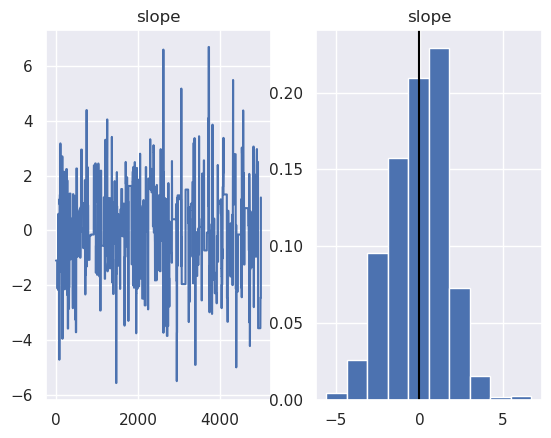

In [22]:
fig, axs = plt.subplots(1,2)
# note the "jaggedness" and apparent autocorrelation in the markov chain;
# this indicates poor mixing and low efficiency
axs[0].plot(slope_samples)
axs[1].hist(slope_samples, density=True)
axs[1].axvline([np.array(slope_samples).mean()], color='black')
axs[0].set_title("slope")
axs[1].set_title("slope")
plt.show()

Unfortunately, this is not a good result. The Markov chain did not converge to the true value and shows signs of [poor mixing](https://en.wikipedia.org/wiki/Markov_chain_mixing_time).

### Automatic inference with pymc

Hopefully you understand now the basic challenges of implementing probabilistic models.

The first step for a practical Bayesian is to choose a suitable **probabilistic programming language** (PPL) in which to build a model.

Let's rewrite our previous model using pymc.

In [23]:
import pymc as pm
import pytensor.tensor as pt # pymc tensor math

def pymc_bayesian_linear(X, y, slope_mean=0.0, intercept_mean=0.0, var_mean=1.0):
    with pm.Model() as model:
        # sample variance from canonincal inverse gamma conjugate prior
        var = pm.InverseGamma("var", 2.0, var_mean)
        sigma = pt.sqrt(var)
        # normally distributed coefficients
        slope = pm.Normal("slope", slope_mean, sigma)
        intercept = pm.Normal("intercept", intercept_mean, sigma)
        # mean prediction
        y_mean = X*slope + intercept
        # specify y as an observed variable
        y = pm.Normal("y", y_mean[:,0], sigma, observed=y)
    return model

blr_model = pymc_bayesian_linear(X, y_obs, var_mean=y_obs.var())
blr_model

      var ~ InverseGamma(2, 0.038)
    slope ~ Normal(0, f(var))
intercept ~ Normal(0, f(var))
        y ~ Normal(f(intercept, slope), f(var))

In [24]:
with blr_model:
    # draw 1000 posterior samples using the gradient-based No-U-Turn sampler
    inference_data = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [var, slope, intercept]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


In [25]:
az.summary(inference_data)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,-0.100,0.024,-0.141,-0.055,0.001,0.000,1781.0,1934.0,1.0
slope,0.483,0.040,0.408,0.558,0.001,0.001,1750.0,1853.0,1.0
var,0.016,0.002,0.012,0.020,0.000,0.000,2406.0,2493.0,1.0


We can use [ArviZ](https://www.arviz.org/en/latest/) to visualize the results.

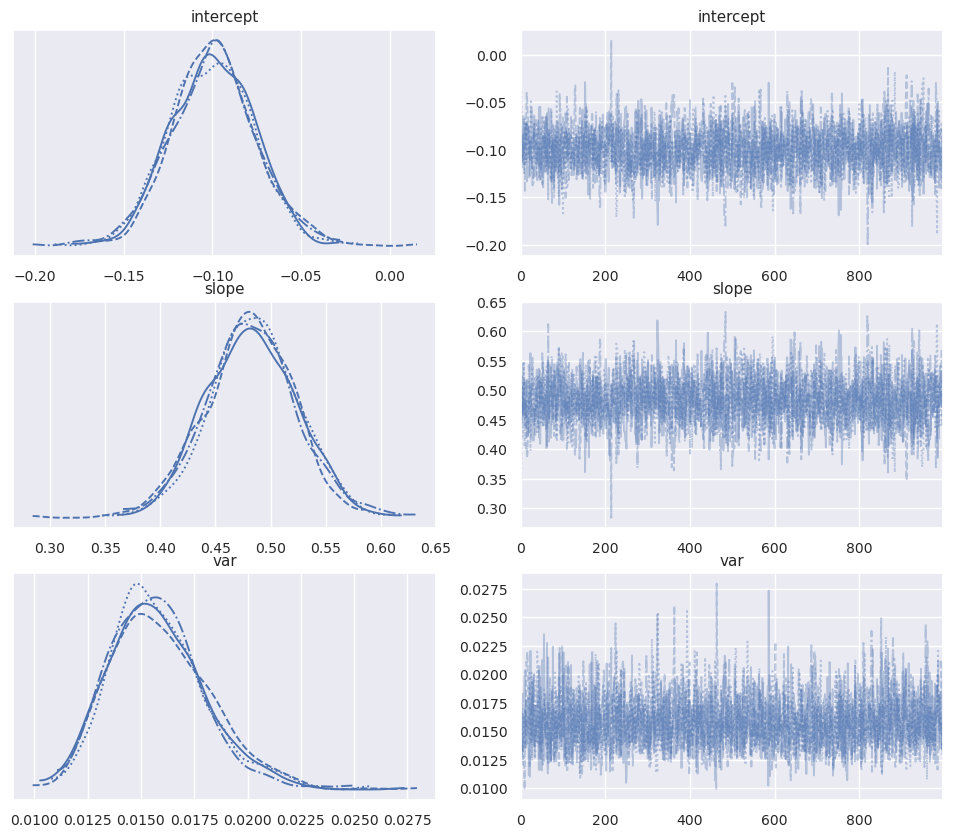

In [26]:
az.plot_trace(inference_data, figsize=(12,10));

### Summary of PPLs

**Python**

[pymc](https://www.pymc.io) (will be used in this tutorial)
- Very elegant and user friendly interface for probabilistic programming in python
- State-of-the-art numerical sampling algorithms (e.g. NUTS)
- Ideal for small to medium scale problems

[pyro](https://www.pyro.ai)
- Built on top of pytorch
- State-of-the-art stochastic variational inference algorithms
- Ideal for deep learning applications and large datasets

[numpyro](https://www.num.pyro.ai)
- Built on top of JAX
- Same basic APIs as pyro with some gaps
- Ideal for more complex models where computational efficiency is important

**Julia**

[Turing.jl](https://turinglang.org/)
- User friendly PPL with very nice syntax
- Very good integration with other Julia packages (e.g. autodiff tools)
- Includes state-of-the-art NUTS sampler as well as some VI support
- Good for most standard statistical modeling use cases

[Gen.jl](https://www.gen.dev)
- Highly flexible "programmable" PPL
- Good support for particle filtering and sequential Monte Carlo algorithms
- Good for use cases that require highly customized inference algorithms
- Less user friendly, high learning curve

[**Stan**](https://mc-stan.org/)
- Very mature and widely used PPL, especially among hardcore statisticians!
- Adaptors exist for **R**, **python**, **Julia**, as well as the shell (**CmdStan**)
- Esoteric syntax, difficult to integrate with non-statistical code